<a href="https://colab.research.google.com/github/HungHoangDinh/GAN/blob/main/DGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from  tensorflow.keras import layers
tf.__version__


'2.19.0'

In [ ]:
(x_train, y_train), (_,_)=tf.keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
x_train.shape

(60000, 28, 28)

6


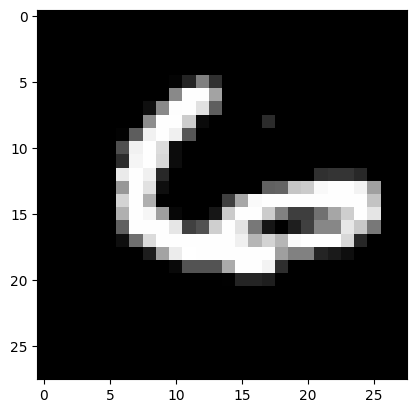

In [ ]:
i=np.random.randint(0,60000)
print(y_train[i])
plt.imshow(x_train[i],cmap="gray" )

In [ ]:
x_train=x_train.reshape(x_train.shape[0],28,28,1).astype("float32")
x_train.shape

(60000, 28, 28, 1)

In [ ]:
x_train=(x_train-127.5)/127.5

In [ ]:
buffer_size=60000
batch_size=250

In [ ]:
x_train=tf.data.Dataset.from_tensor_slices(x_train).shuffle(buffer_size).batch(batch_size)

In [ ]:
x_train

<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

In [ ]:
def build_generator():
  network=tf.keras.Sequential()
  network.add(layers.Dense(units=7*7*256,use_bias=False, input_shape=(100,)))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())
  network.add(layers.Reshape((7,7,256)))
  # 7*7*128
  network.add(layers.Conv2DTranspose(filters=128,kernel_size=(5,5),strides=(1,1),padding="same",use_bias=False))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  # 14 *14*64.
  network.add(layers.Conv2DTranspose(filters=64,kernel_size=(5,5),padding=
                                     "same",use_bias=False,strides=(2,2)))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())
  #28*28*1
  network.add(layers.Conv2DTranspose(filters=1,kernel_size=(5,5),padding=
                                     "same",use_bias=False,strides=(2,2)))
  network.add(layers.Activation("tanh"))
  network.summary()
  return network



In [ ]:
generator=build_generator()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 12544)          │     1,254,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 12544)          │        50,176 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 7, 7, 128)      │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 14, 14, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │         1,600 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 28, 28, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,330,944 (8.89 MB)

 Trainable params: 2,305,472 (8.79 MB)

 Non-trainable params: 25,472 (99.50 KB)

In [ ]:
noise=tf.random.normal([1,100])

In [ ]:
def build_discriminator():
  network=tf.keras.Sequential()
  #28*28*1 is input, 14*14*64 is output
  network.add(layers.Conv2D(filters=64,kernel_size=(5,5),strides=(2,2),padding="same",input_shape=[28,28,1]))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))
  #14*14*64 is input, 7*7*128 is output
  network.add(layers.Conv2D(filters=128,kernel_size=(5,5),strides=(2,2),padding="same"))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))
  # flatten
  network.add(layers.Flatten())
  network.add(layers.Dense(units=1,activation="sigmoid"))
  network.summary()
  return network



In [ ]:
discriminator=build_discriminator()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cross_entropy=tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(expect_output,fake_output):
  real_loss=cross_entropy(tf.ones_like(expect_output),expect_output)
  fake_loss=cross_entropy(tf.zeros_like(fake_output),fake_output)
  total_loss=real_loss+fake_loss
  return total_loss

In [ ]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output),fake_output)

In [ ]:
generator_optimizer=tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer=tf.keras.optimizers.Adam(1e-4)

In [ ]:
x_train

<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

In [ ]:
epochs=100
noise_dimension=100
number_of_images=16

In [ ]:
batch_size

250

In [ ]:
@tf.function
def train_step(images):
  noise=tf.random.normal([batch_size,noise_dimension])
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images=generator(noise,training=True)
    real_output=discriminator(images,training=True)
    fake_output=discriminator(generated_images,training=True)
    discriminator_loss_value=discriminator_loss(real_output,fake_output)
    generator_loss_value=generator_loss(fake_output)
  gradients_of_generator=gen_tape.gradient(generator_loss_value,generator.trainable_variables)
  gradients_of_discriminator=disc_tape.gradient(discriminator_loss_value,discriminator.trainable_variables)
  generator_optimizer.apply_gradients(zip(gradients_of_generator,generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator,discriminator.trainable_variables))
  return generator_loss_value,discriminator_loss_value

In [ ]:
test_images=tf.random.normal([number_of_images,noise_dimension])


In [ ]:
def train_gan(dataset,epochs, test_images):
  for epoch in range(epochs):
    generator_loss_epoch=0
    discriminator_loss_epoch=0
    for image_batch in dataset:
      generator_loss_value,discriminator_loss_value=train_step(image_batch)
    print("Epoch: ", epoch+1)
    generated_images=generator(test_images,training=False)
    for i in range(generated_images.shape[0]):
      plt.subplot(4,4,i+1)
      plt.imshow(generated_images[i,:,:,0]*127.5+127.5,cmap="gray")
      plt.axis("off")
      plt.show()

/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/nn.py:789: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch:  1


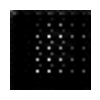

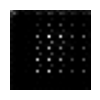

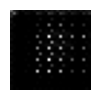

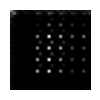

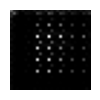

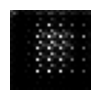

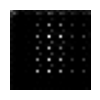

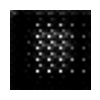

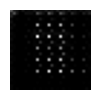

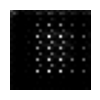

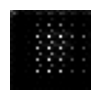

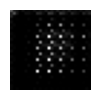

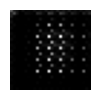

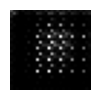

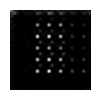

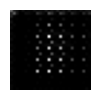

Epoch:  2


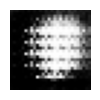

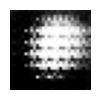

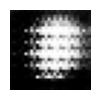

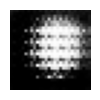

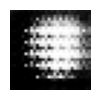

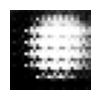

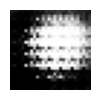

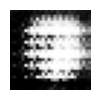

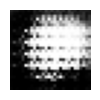

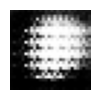

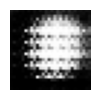

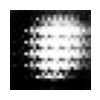

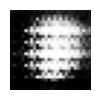

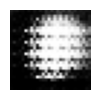

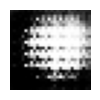

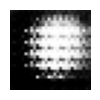

Epoch:  3


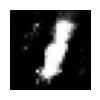

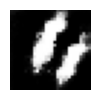

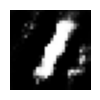

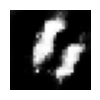

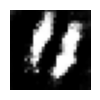

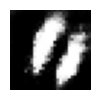

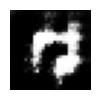

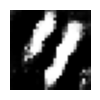

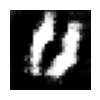

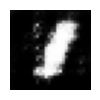

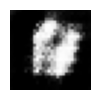

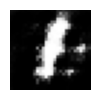

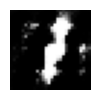

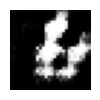

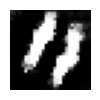

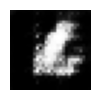

Epoch:  4


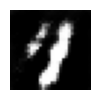

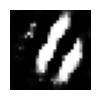

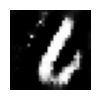

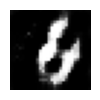

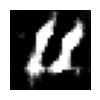

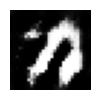

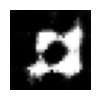

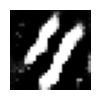

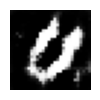

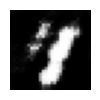

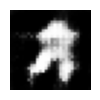

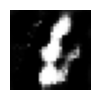

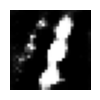

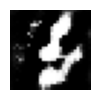

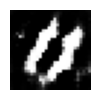

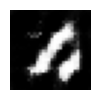

Epoch:  5


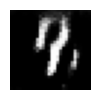

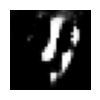

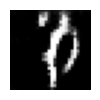

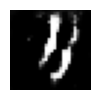

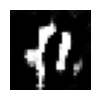

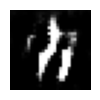

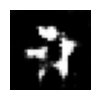

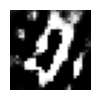

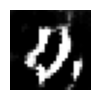

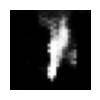

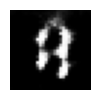

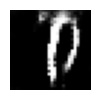

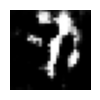

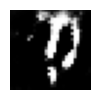

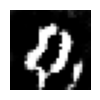

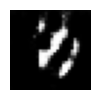

Epoch:  6


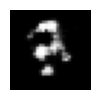

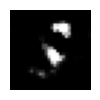

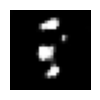

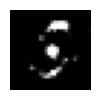

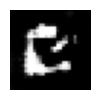

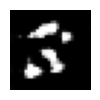

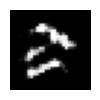

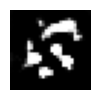

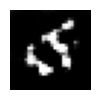

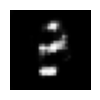

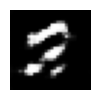

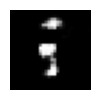

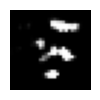

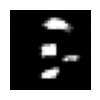

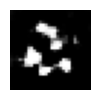

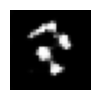

Epoch:  7


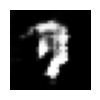

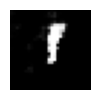

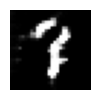

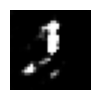

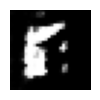

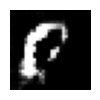

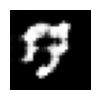

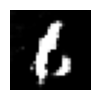

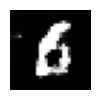

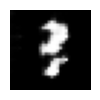

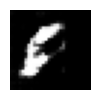

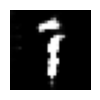

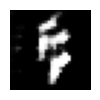

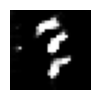

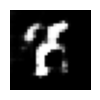

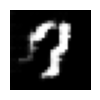

Epoch:  8


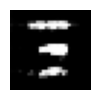

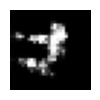

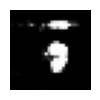

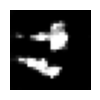

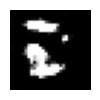

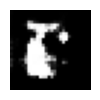

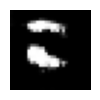

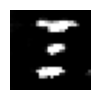

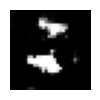

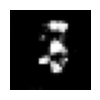

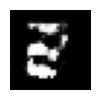

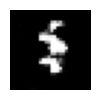

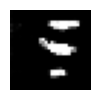

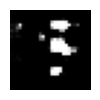

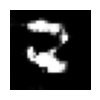

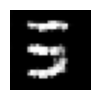

Epoch:  9


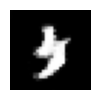

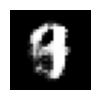

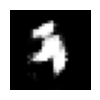

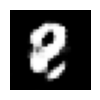

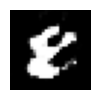

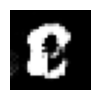

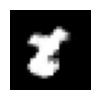

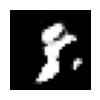

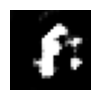

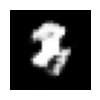

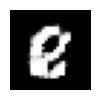

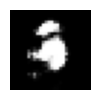

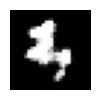

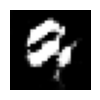

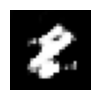

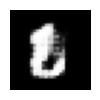

Epoch:  10


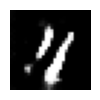

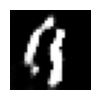

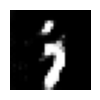

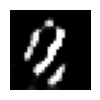

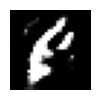

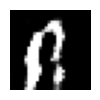

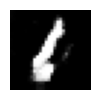

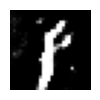

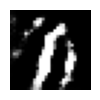

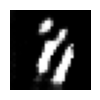

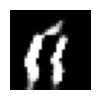

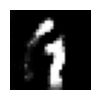

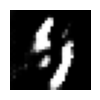

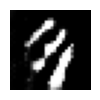

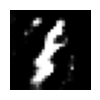

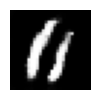

Epoch:  11


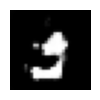

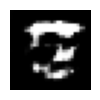

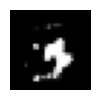

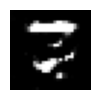

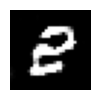

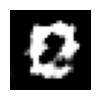

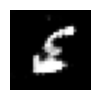

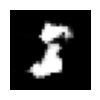

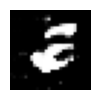

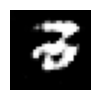

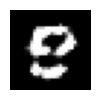

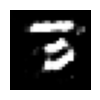

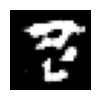

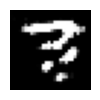

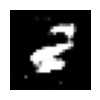

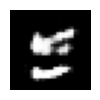

Epoch:  12


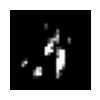

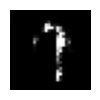

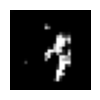

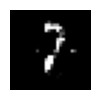

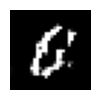

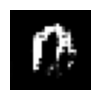

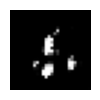

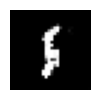

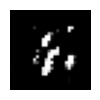

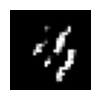

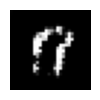

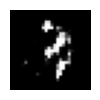

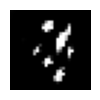

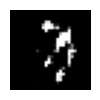

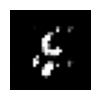

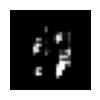

Epoch:  13


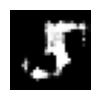

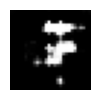

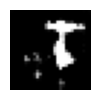

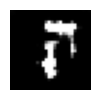

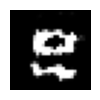

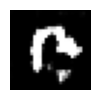

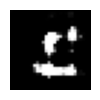

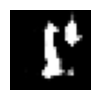

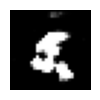

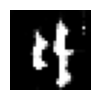

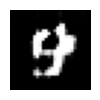

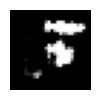

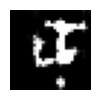

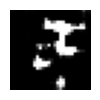

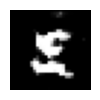

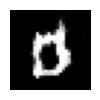

Epoch:  14


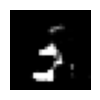

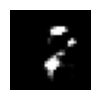

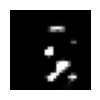

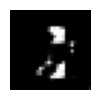

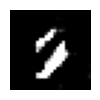

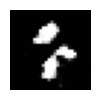

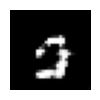

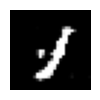

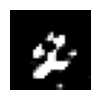

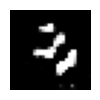

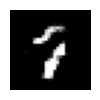

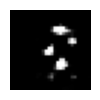

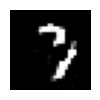

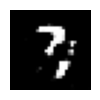

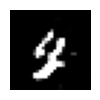

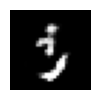

Epoch:  15


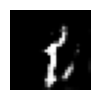

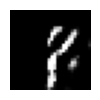

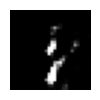

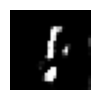

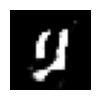

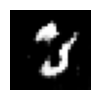

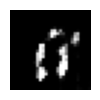

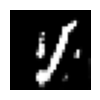

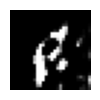

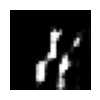

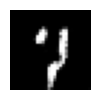

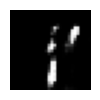

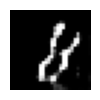

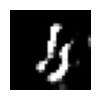

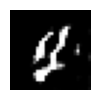

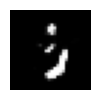

Epoch:  16


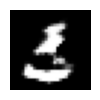

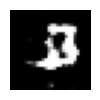

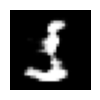

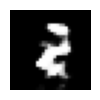

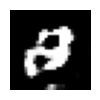

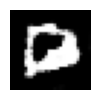

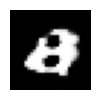

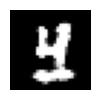

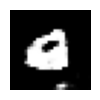

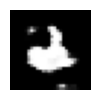

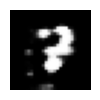

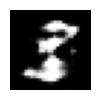

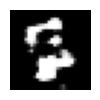

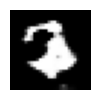

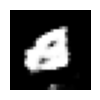

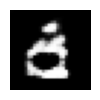

Epoch:  17


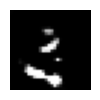

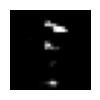

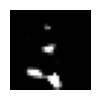

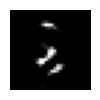

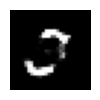

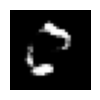

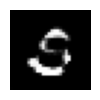

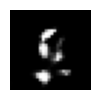

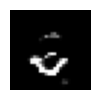

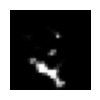

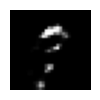

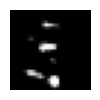

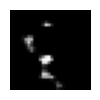

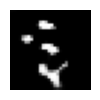

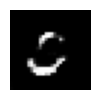

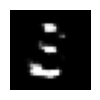

Epoch:  18


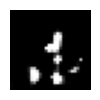

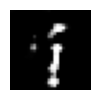

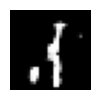

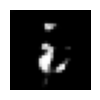

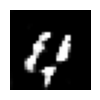

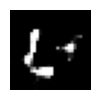

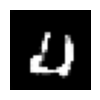

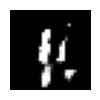

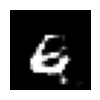

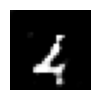

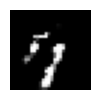

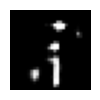

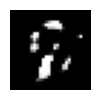

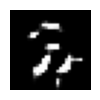

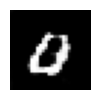

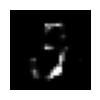

Epoch:  19


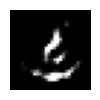

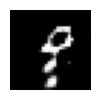

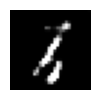

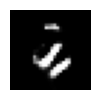

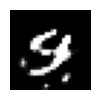

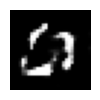

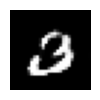

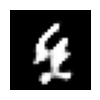

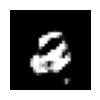

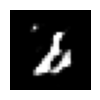

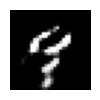

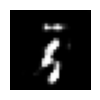

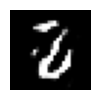

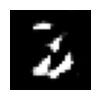

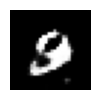

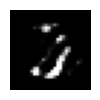

Epoch:  20


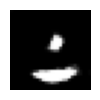

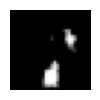

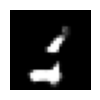

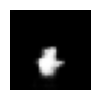

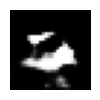

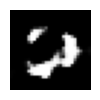

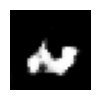

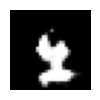

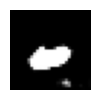

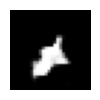

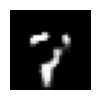

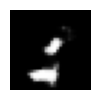

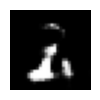

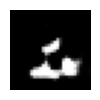

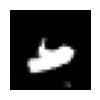

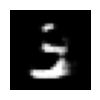

Epoch:  21


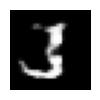

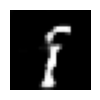

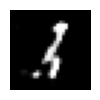

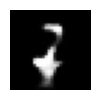

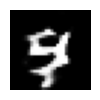

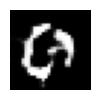

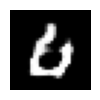

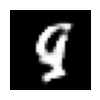

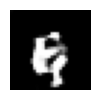

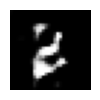

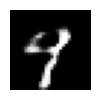

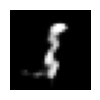

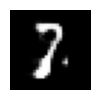

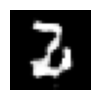

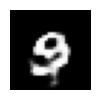

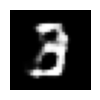

Epoch:  22


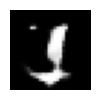

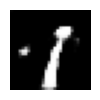

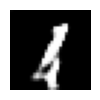

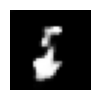

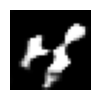

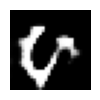

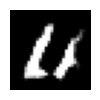

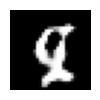

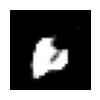

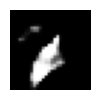

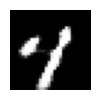

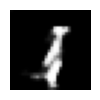

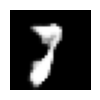

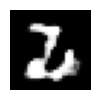

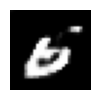

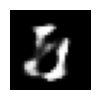

Epoch:  23


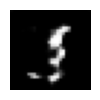

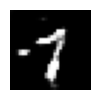

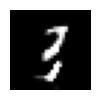

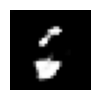

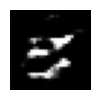

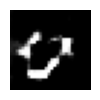

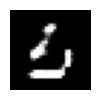

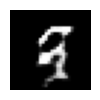

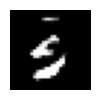

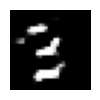

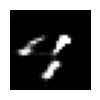

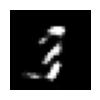

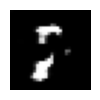

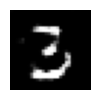

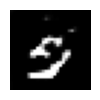

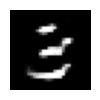

Epoch:  24


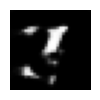

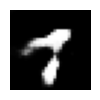

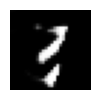

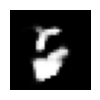

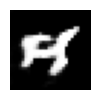

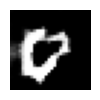

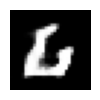

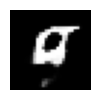

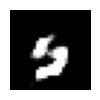

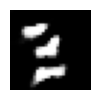

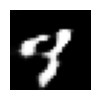

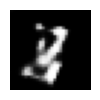

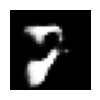

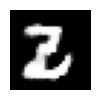

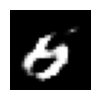

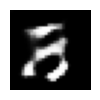

Epoch:  25


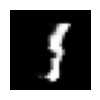

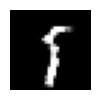

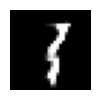

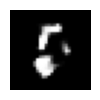

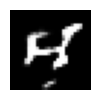

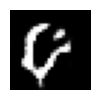

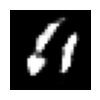

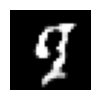

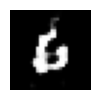

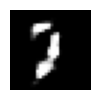

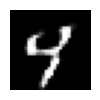

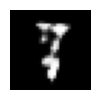

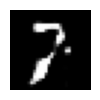

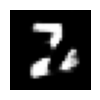

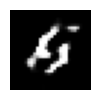

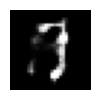

Epoch:  26


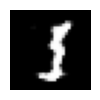

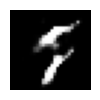

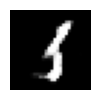

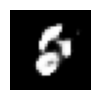

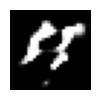

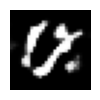

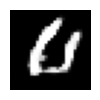

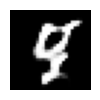

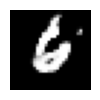

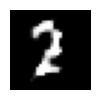

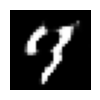

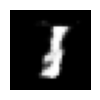

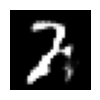

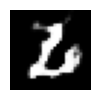

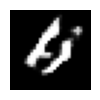

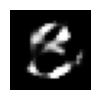

Epoch:  27


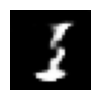

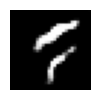

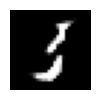

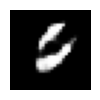

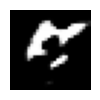

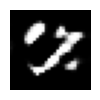

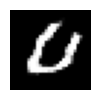

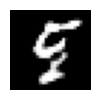

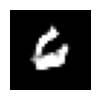

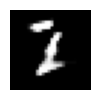

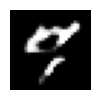

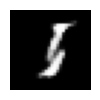

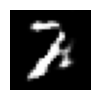

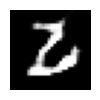

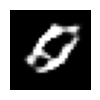

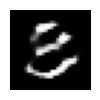

Epoch:  28


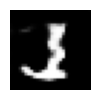

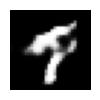

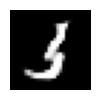

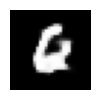

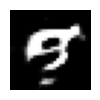

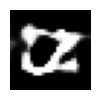

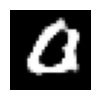

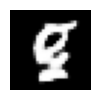

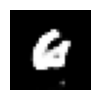

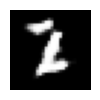

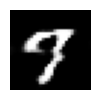

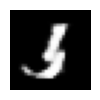

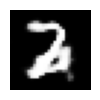

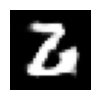

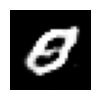

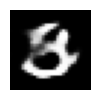

Epoch:  29


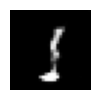

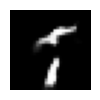

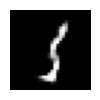

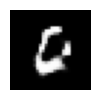

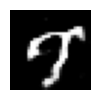

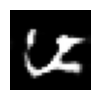

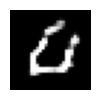

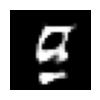

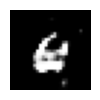

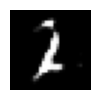

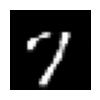

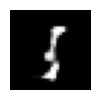

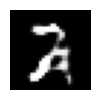

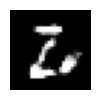

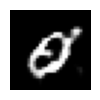

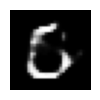

Epoch:  30


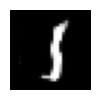

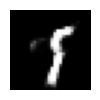

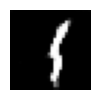

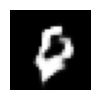

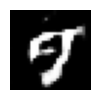

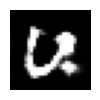

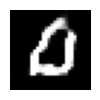

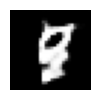

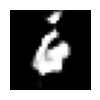

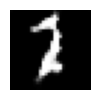

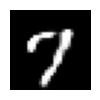

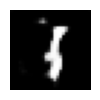

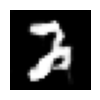

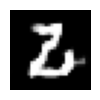

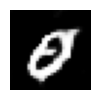

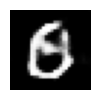

Epoch:  31


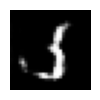

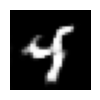

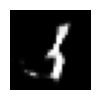

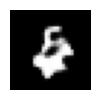

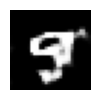

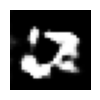

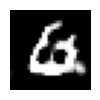

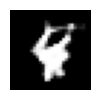

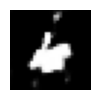

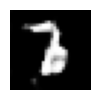

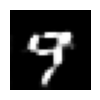

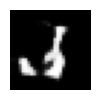

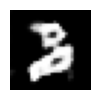

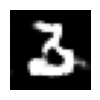

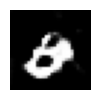

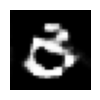

Epoch:  32


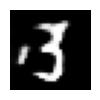

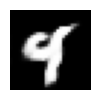

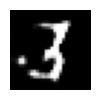

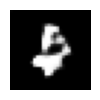

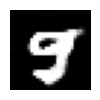

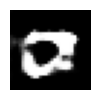

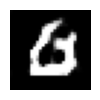

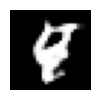

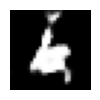

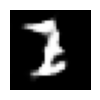

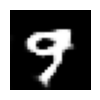

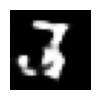

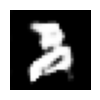

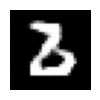

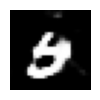

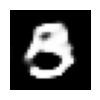

Epoch:  33


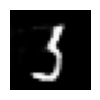

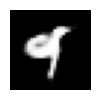

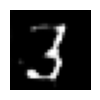

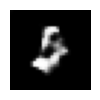

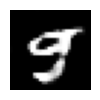

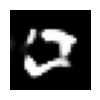

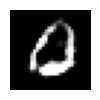

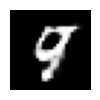

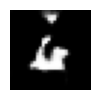

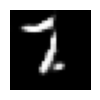

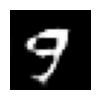

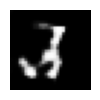

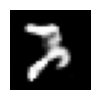

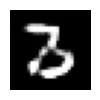

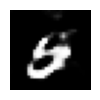

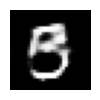

Epoch:  34


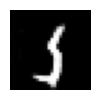

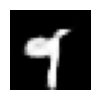

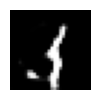

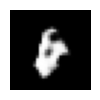

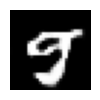

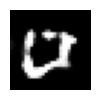

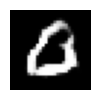

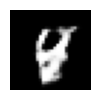

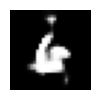

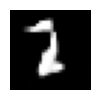

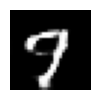

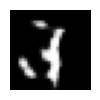

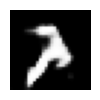

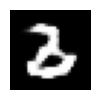

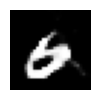

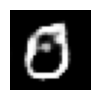

Epoch:  35


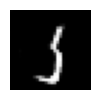

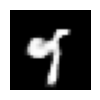

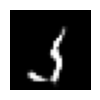

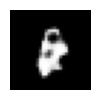

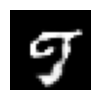

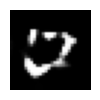

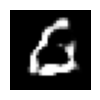

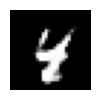

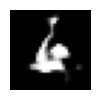

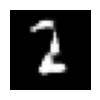

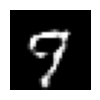

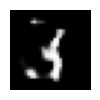

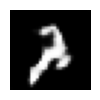

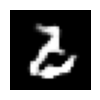

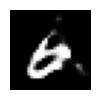

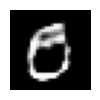

Epoch:  36


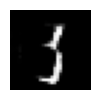

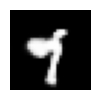

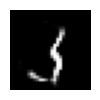

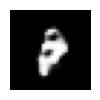

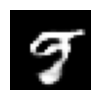

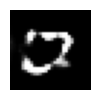

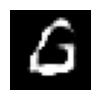

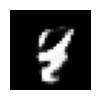

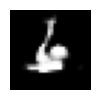

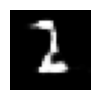

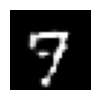

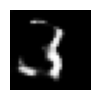

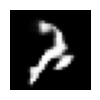

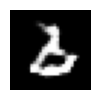

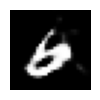

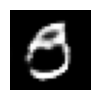

Epoch:  37


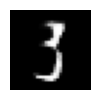

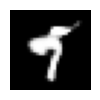

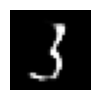

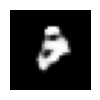

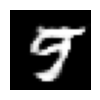

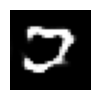

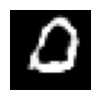

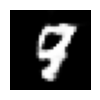

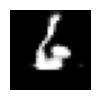

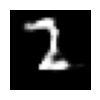

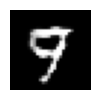

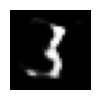

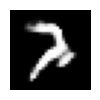

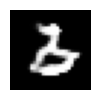

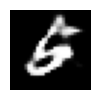

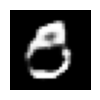

Epoch:  38


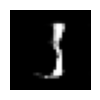

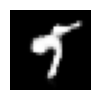

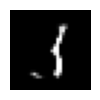

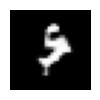

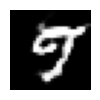

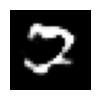

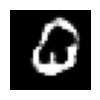

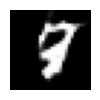

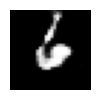

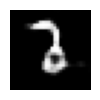

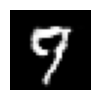

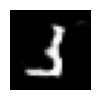

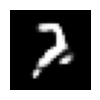

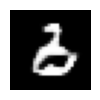

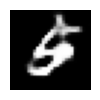

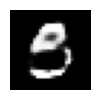

Epoch:  39


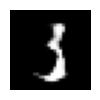

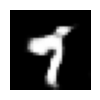

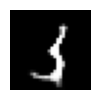

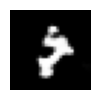

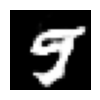

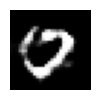

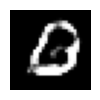

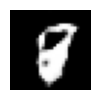

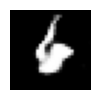

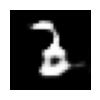

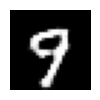

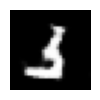

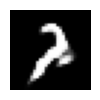

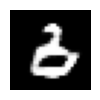

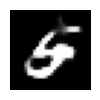

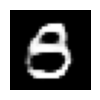

Epoch:  40


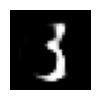

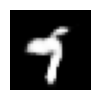

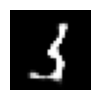

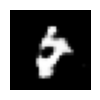

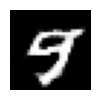

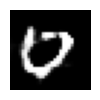

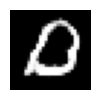

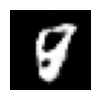

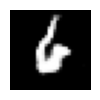

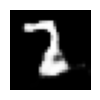

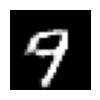

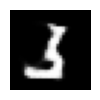

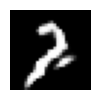

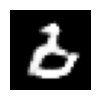

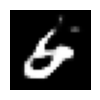

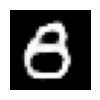

Epoch:  41


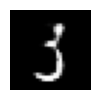

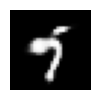

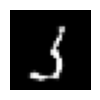

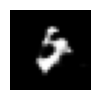

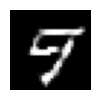

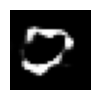

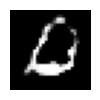

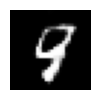

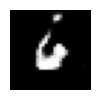

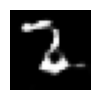

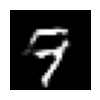

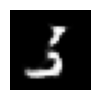

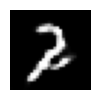

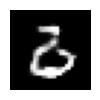

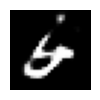

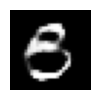

Epoch:  42


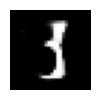

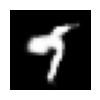

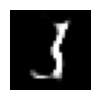

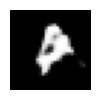

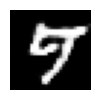

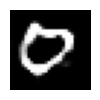

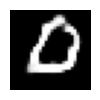

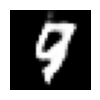

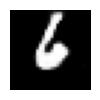

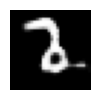

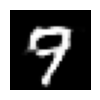

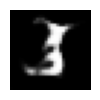

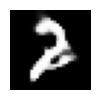

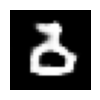

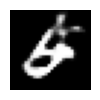

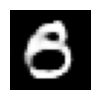

Epoch:  43


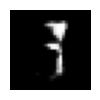

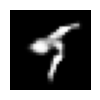

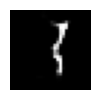

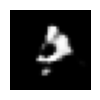

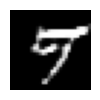

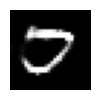

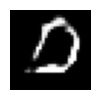

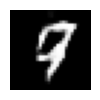

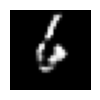

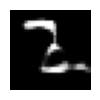

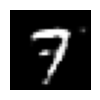

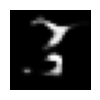

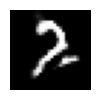

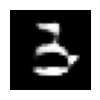

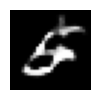

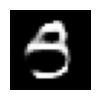

Epoch:  44


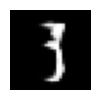

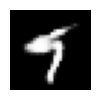

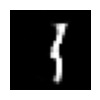

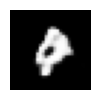

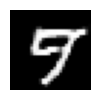

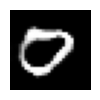

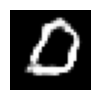

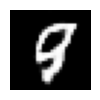

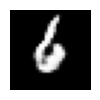

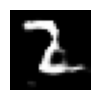

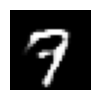

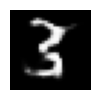

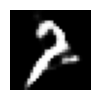

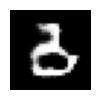

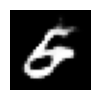

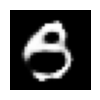

Epoch:  45


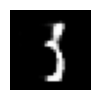

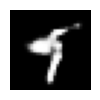

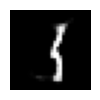

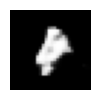

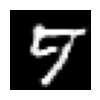

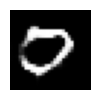

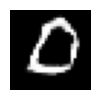

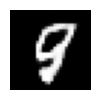

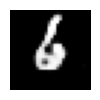

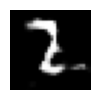

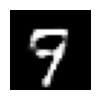

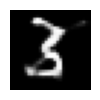

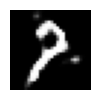

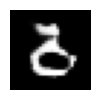

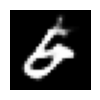

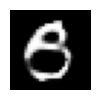

Epoch:  46


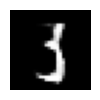

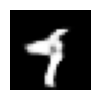

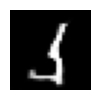

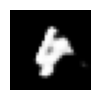

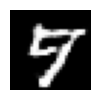

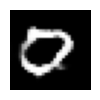

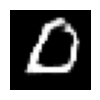

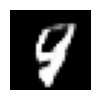

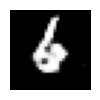

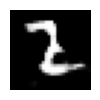

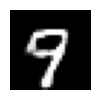

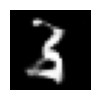

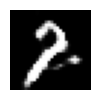

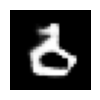

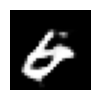

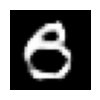

Epoch:  47


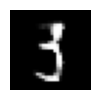

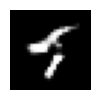

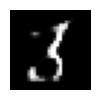

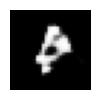

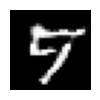

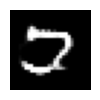

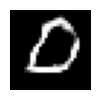

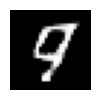

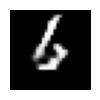

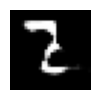

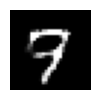

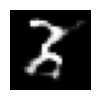

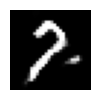

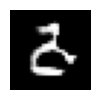

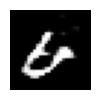

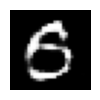

Epoch:  48


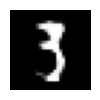

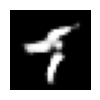

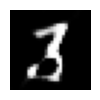

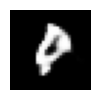

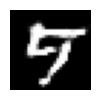

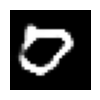

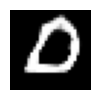

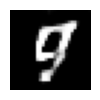

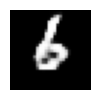

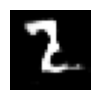

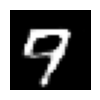

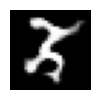

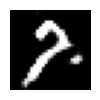

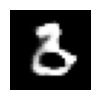

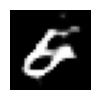

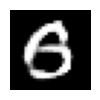

Epoch:  49


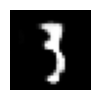

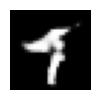

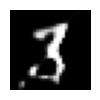

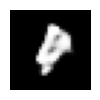

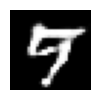

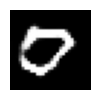

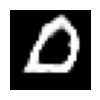

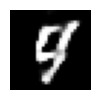

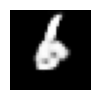

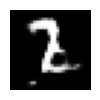

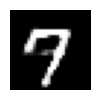

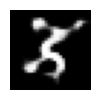

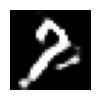

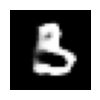

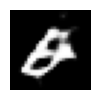

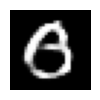

Epoch:  50


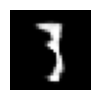

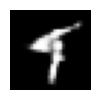

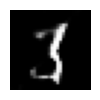

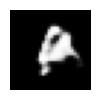

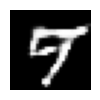

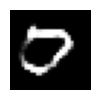

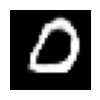

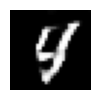

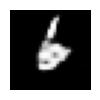

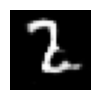

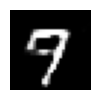

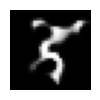

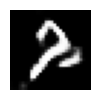

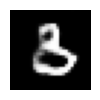

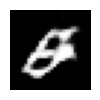

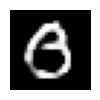

Epoch:  51


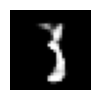

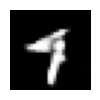

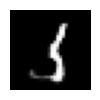

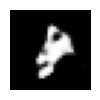

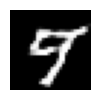

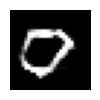

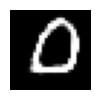

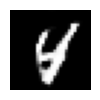

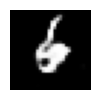

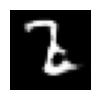

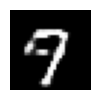

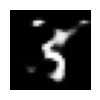

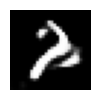

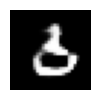

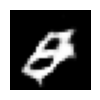

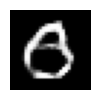

Epoch:  52


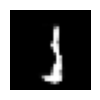

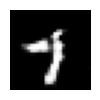

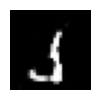

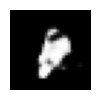

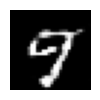

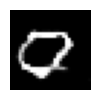

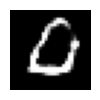

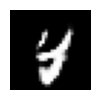

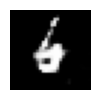

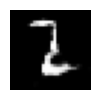

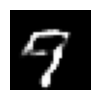

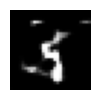

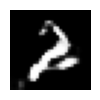

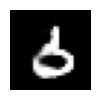

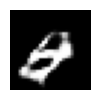

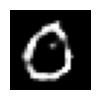

Epoch:  53


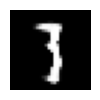

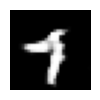

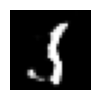

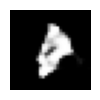

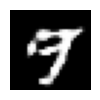

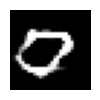

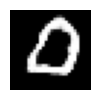

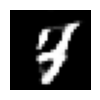

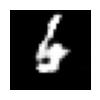

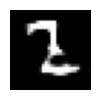

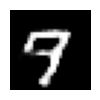

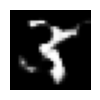

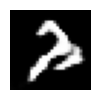

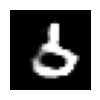

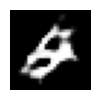

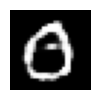

Epoch:  54


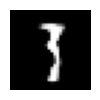

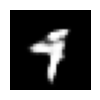

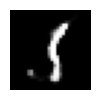

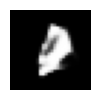

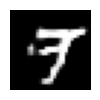

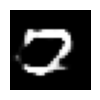

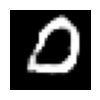

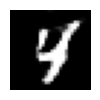

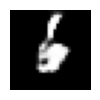

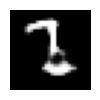

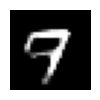

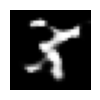

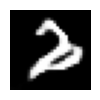

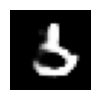

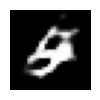

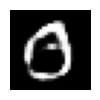

Epoch:  55


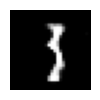

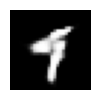

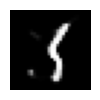

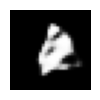

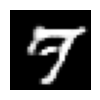

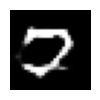

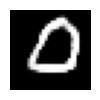

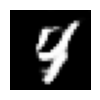

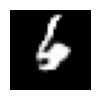

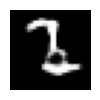

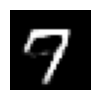

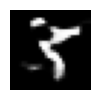

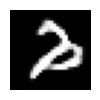

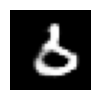

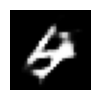

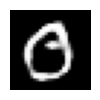

Epoch:  56


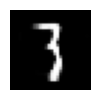

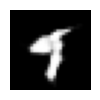

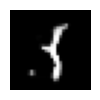

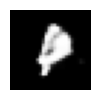

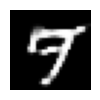

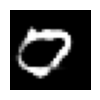

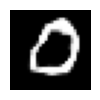

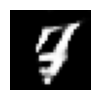

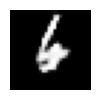

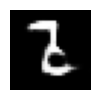

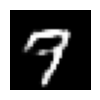

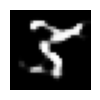

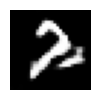

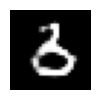

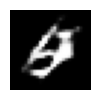

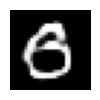

Epoch:  57


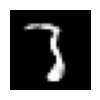

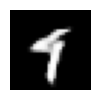

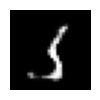

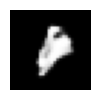

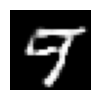

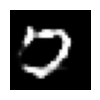

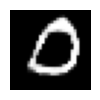

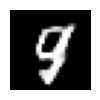

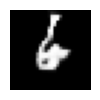

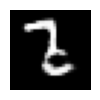

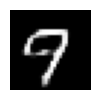

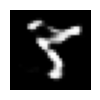

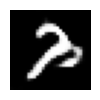

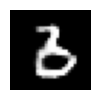

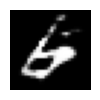

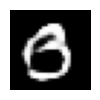

Epoch:  58


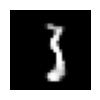

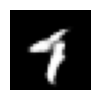

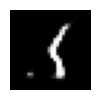

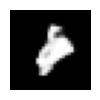

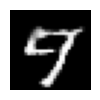

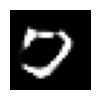

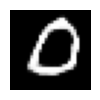

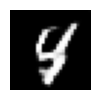

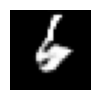

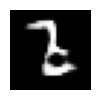

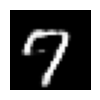

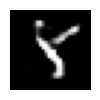

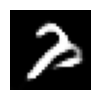

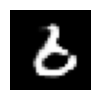

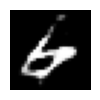

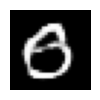

Epoch:  59


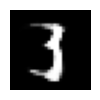

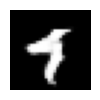

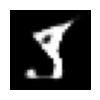

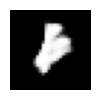

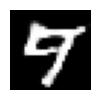

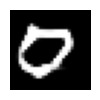

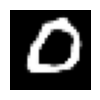

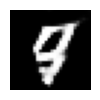

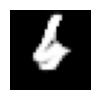

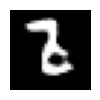

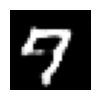

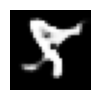

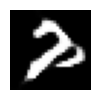

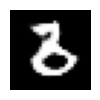

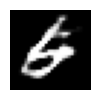

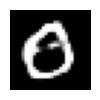

Epoch:  60


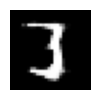

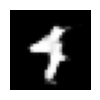

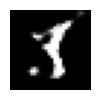

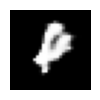

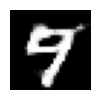

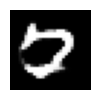

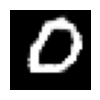

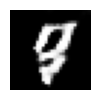

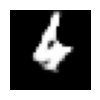

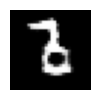

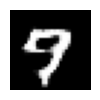

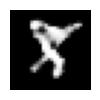

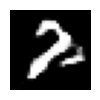

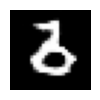

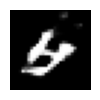

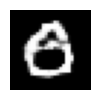

Epoch:  61


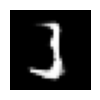

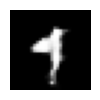

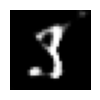

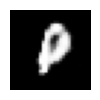

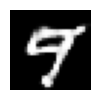

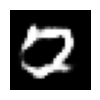

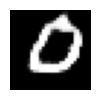

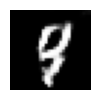

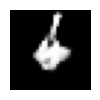

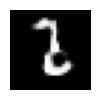

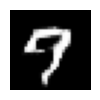

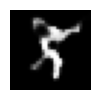

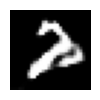

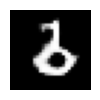

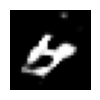

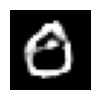

Epoch:  62


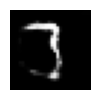

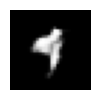

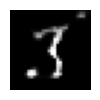

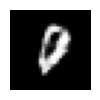

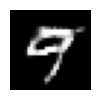

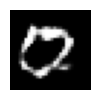

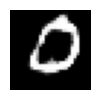

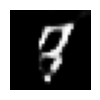

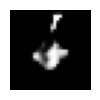

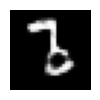

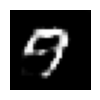

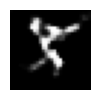

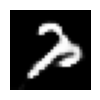

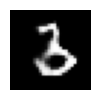

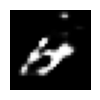

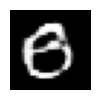

Epoch:  63


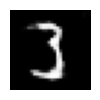

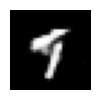

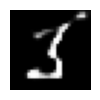

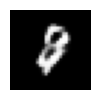

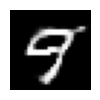

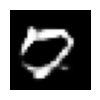

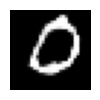

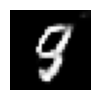

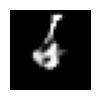

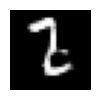

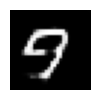

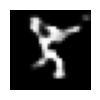

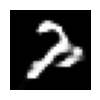

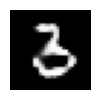

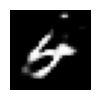

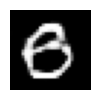

Epoch:  64


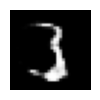

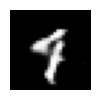

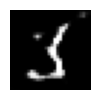

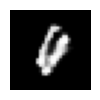

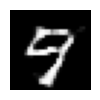

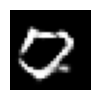

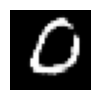

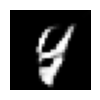

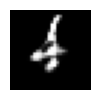

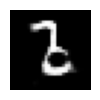

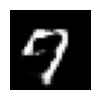

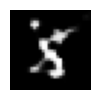

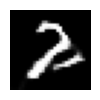

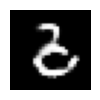

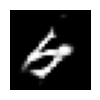

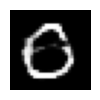

Epoch:  65


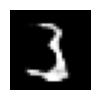

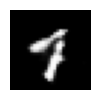

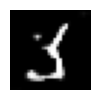

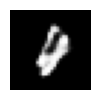

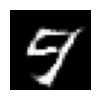

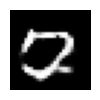

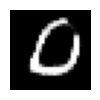

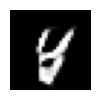

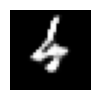

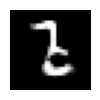

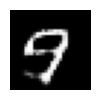

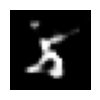

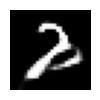

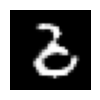

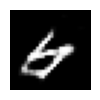

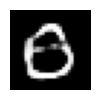

Epoch:  66


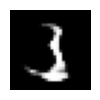

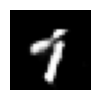

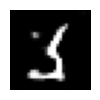

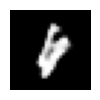

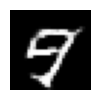

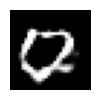

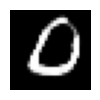

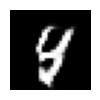

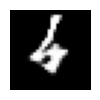

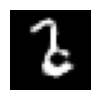

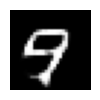

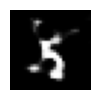

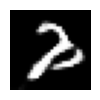

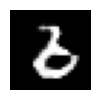

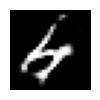

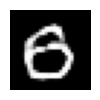

Epoch:  67


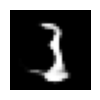

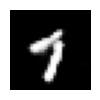

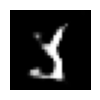

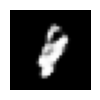

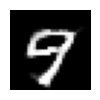

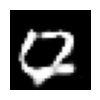

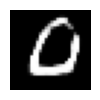

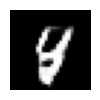

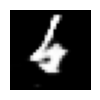

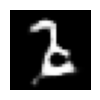

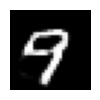

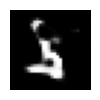

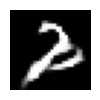

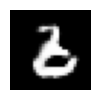

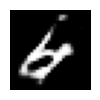

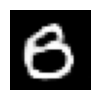

Epoch:  68


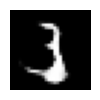

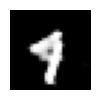

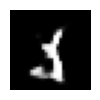

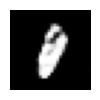

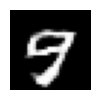

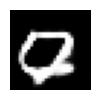

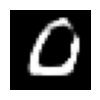

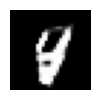

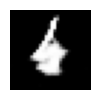

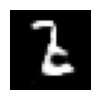

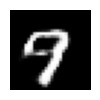

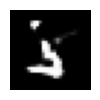

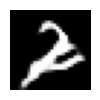

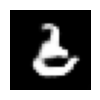

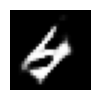

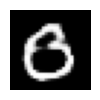

Epoch:  69


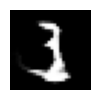

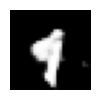

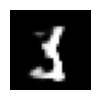

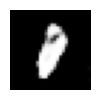

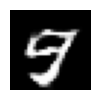

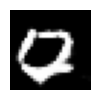

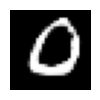

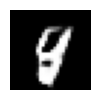

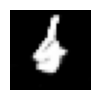

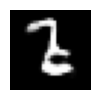

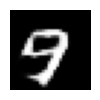

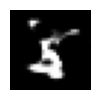

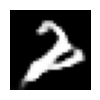

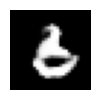

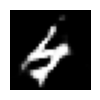

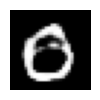

Epoch:  70


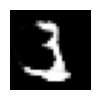

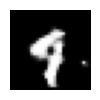

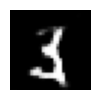

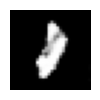

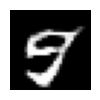

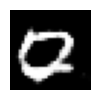

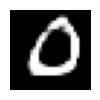

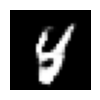

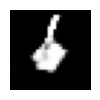

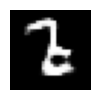

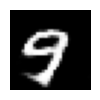

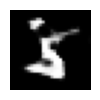

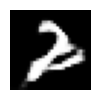

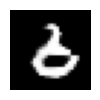

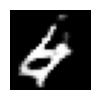

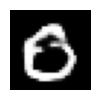

Epoch:  71


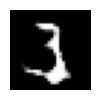

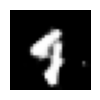

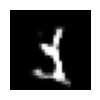

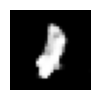

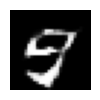

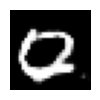

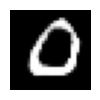

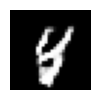

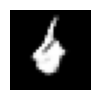

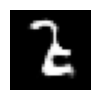

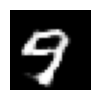

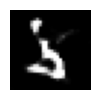

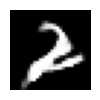

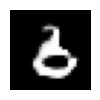

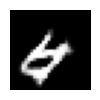

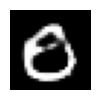

Epoch:  72


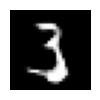

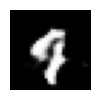

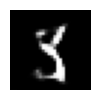

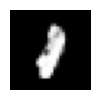

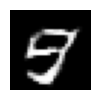

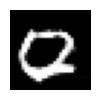

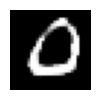

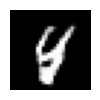

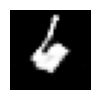

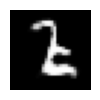

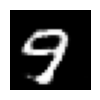

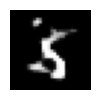

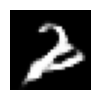

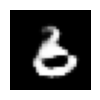

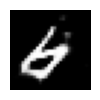

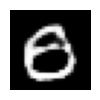

Epoch:  73


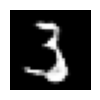

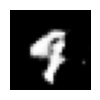

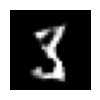

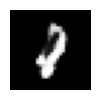

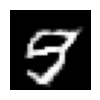

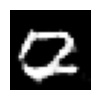

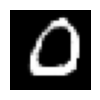

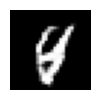

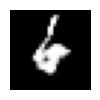

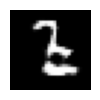

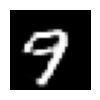

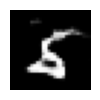

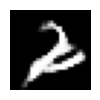

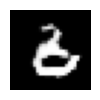

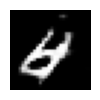

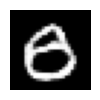

Epoch:  74


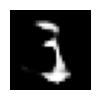

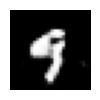

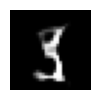

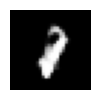

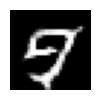

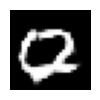

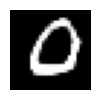

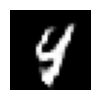

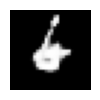

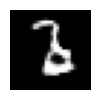

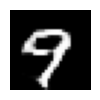

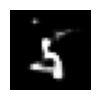

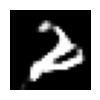

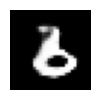

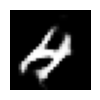

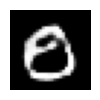

Epoch:  75


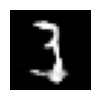

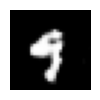

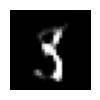

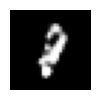

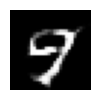

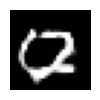

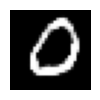

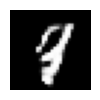

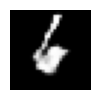

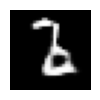

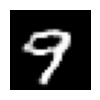

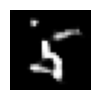

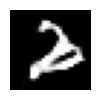

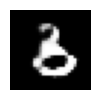

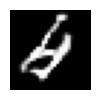

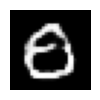

Epoch:  76


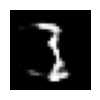

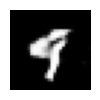

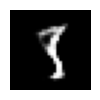

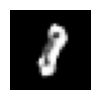

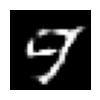

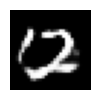

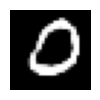

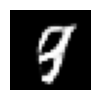

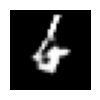

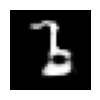

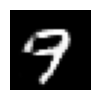

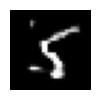

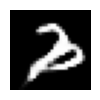

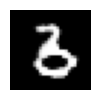

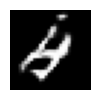

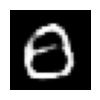

Epoch:  77


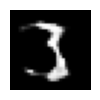

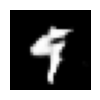

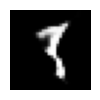

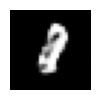

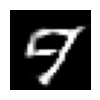

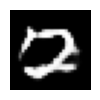

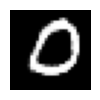

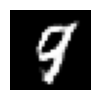

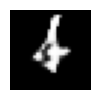

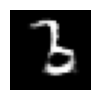

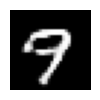

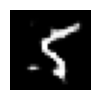

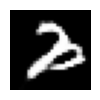

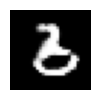

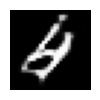

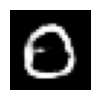

Epoch:  78


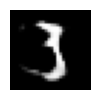

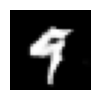

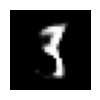

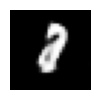

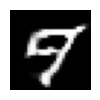

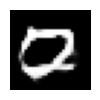

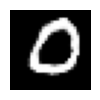

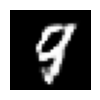

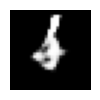

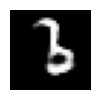

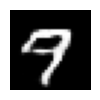

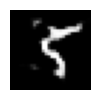

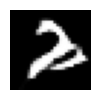

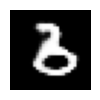

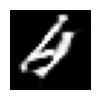

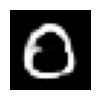

Epoch:  79


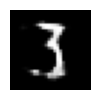

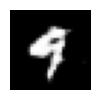

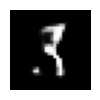

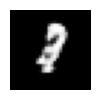

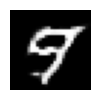

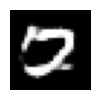

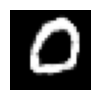

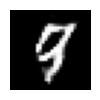

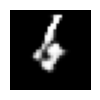

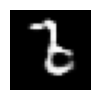

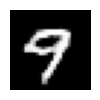

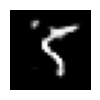

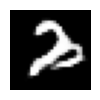

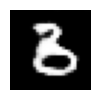

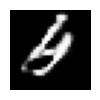

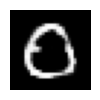

Epoch:  80


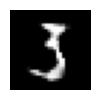

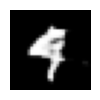

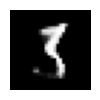

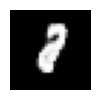

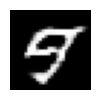

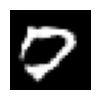

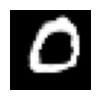

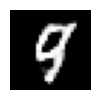

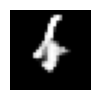

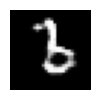

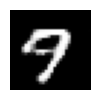

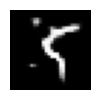

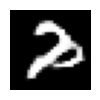

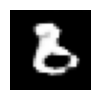

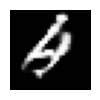

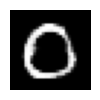

Epoch:  81


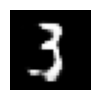

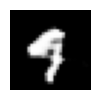

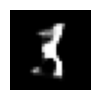

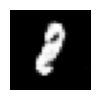

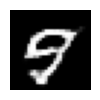

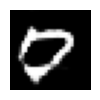

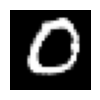

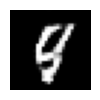

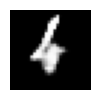

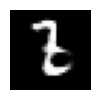

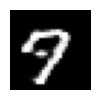

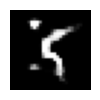

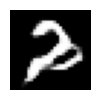

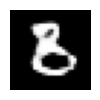

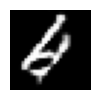

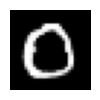

Epoch:  82


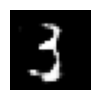

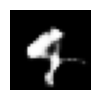

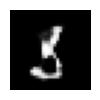

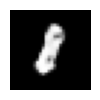

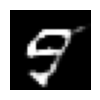

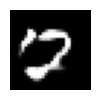

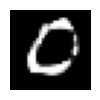

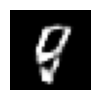

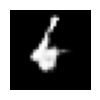

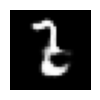

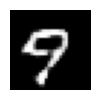

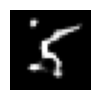

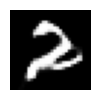

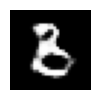

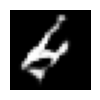

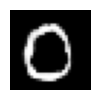

Epoch:  83


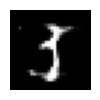

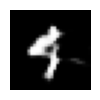

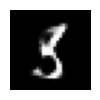

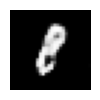

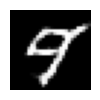

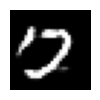

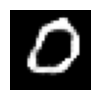

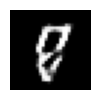

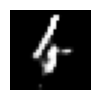

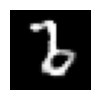

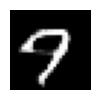

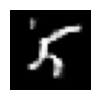

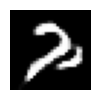

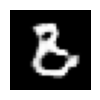

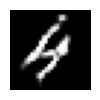

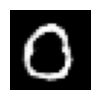

Epoch:  84


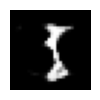

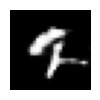

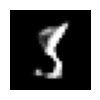

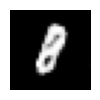

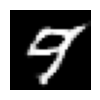

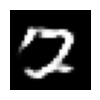

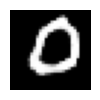

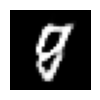

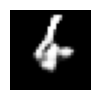

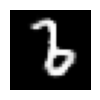

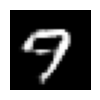

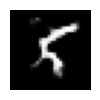

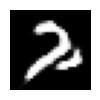

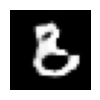

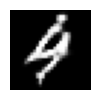

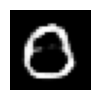

Epoch:  85


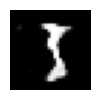

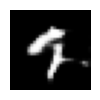

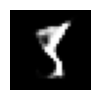

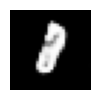

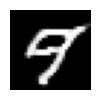

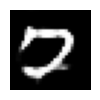

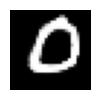

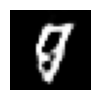

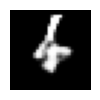

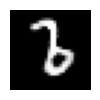

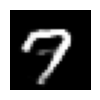

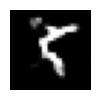

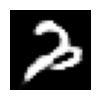

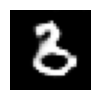

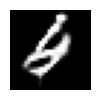

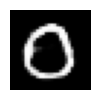

Epoch:  86


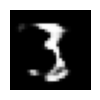

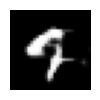

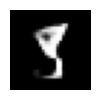

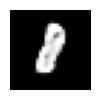

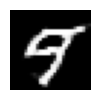

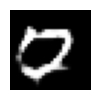

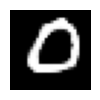

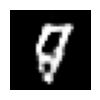

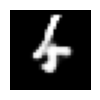

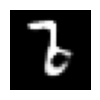

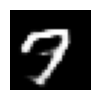

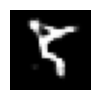

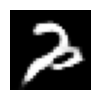

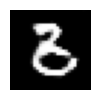

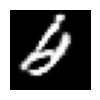

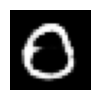

Epoch:  87


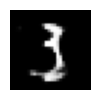

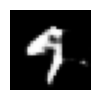

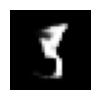

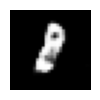

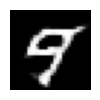

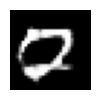

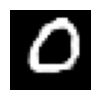

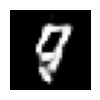

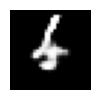

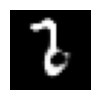

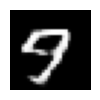

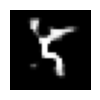

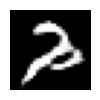

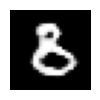

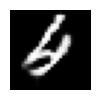

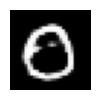

Epoch:  88


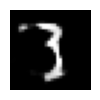

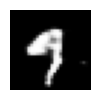

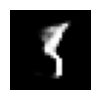

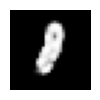

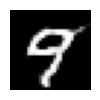

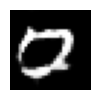

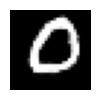

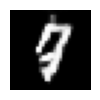

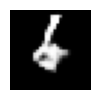

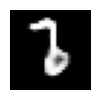

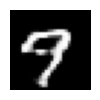

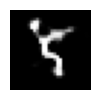

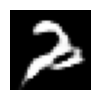

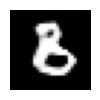

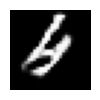

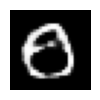

Epoch:  89


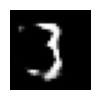

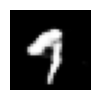

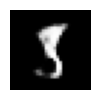

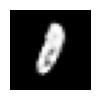

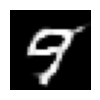

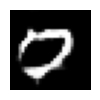

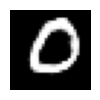

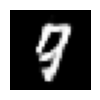

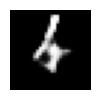

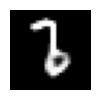

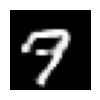

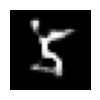

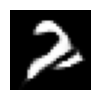

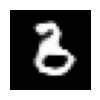

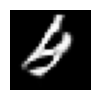

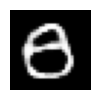

Epoch:  90


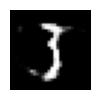

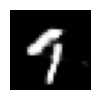

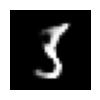

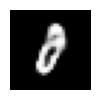

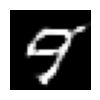

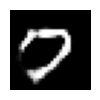

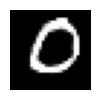

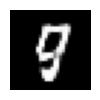

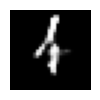

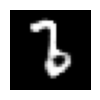

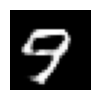

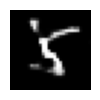

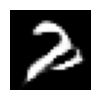

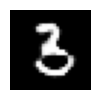

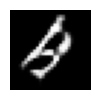

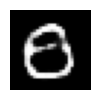

Epoch:  91


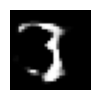

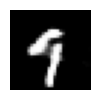

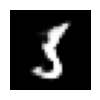

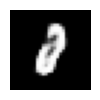

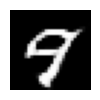

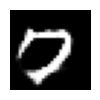

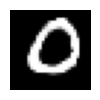

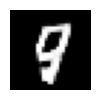

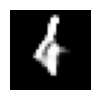

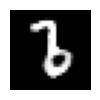

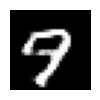

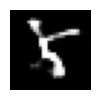

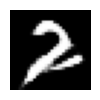

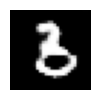

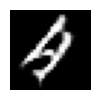

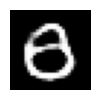

Epoch:  92


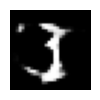

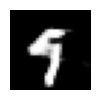

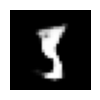

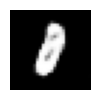

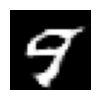

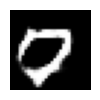

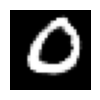

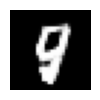

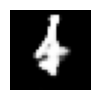

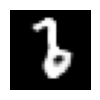

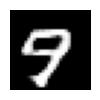

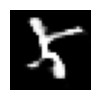

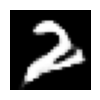

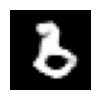

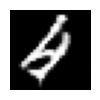

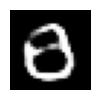

Epoch:  93


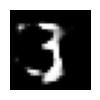

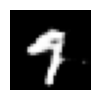

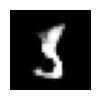

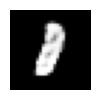

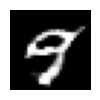

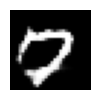

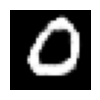

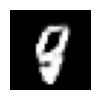

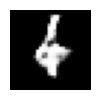

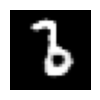

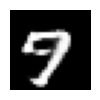

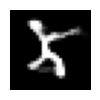

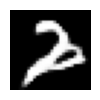

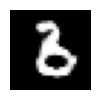

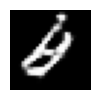

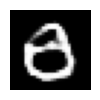

Epoch:  94


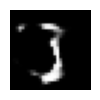

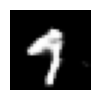

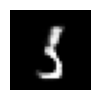

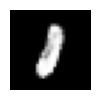

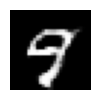

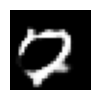

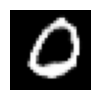

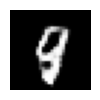

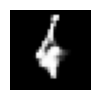

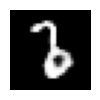

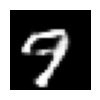

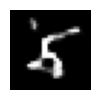

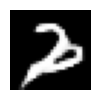

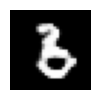

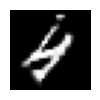

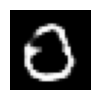

Epoch:  95


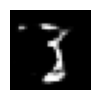

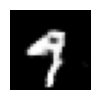

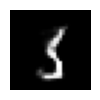

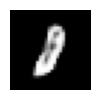

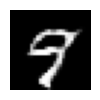

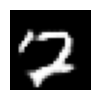

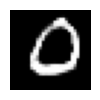

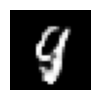

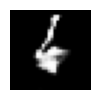

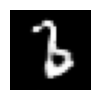

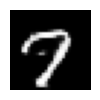

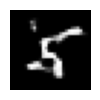

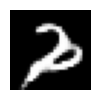

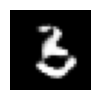

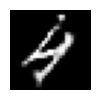

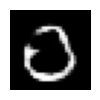

Epoch:  96


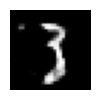

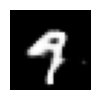

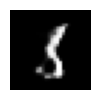

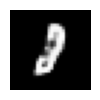

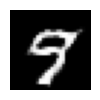

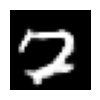

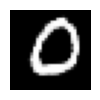

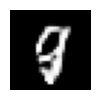

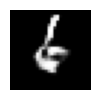

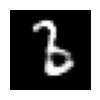

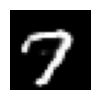

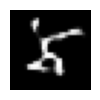

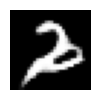

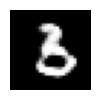

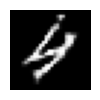

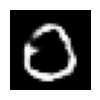

Epoch:  97


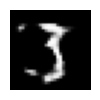

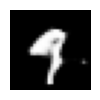

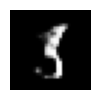

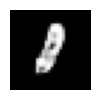

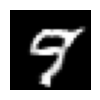

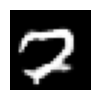

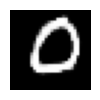

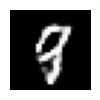

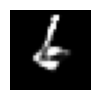

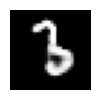

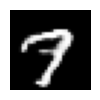

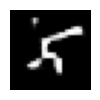

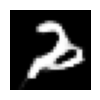

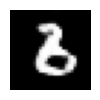

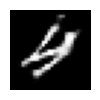

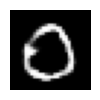

Epoch:  98


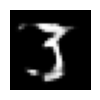

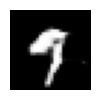

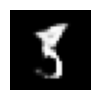

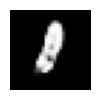

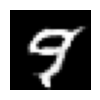

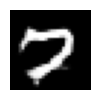

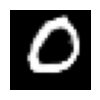

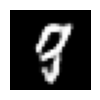

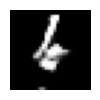

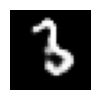

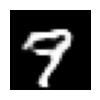

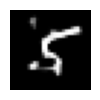

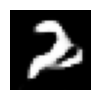

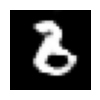

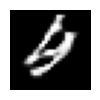

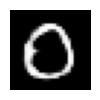

Epoch:  99


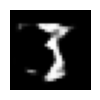

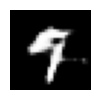

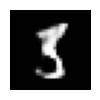

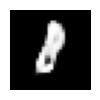

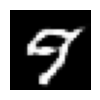

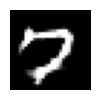

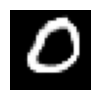

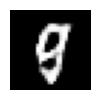

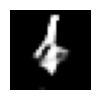

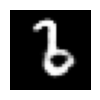

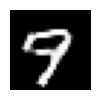

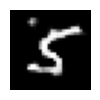

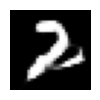

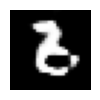

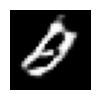

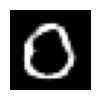

Epoch:  100


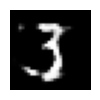

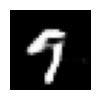

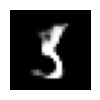

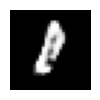

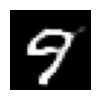

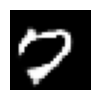

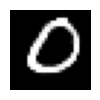

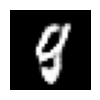

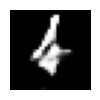

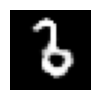

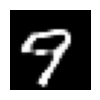

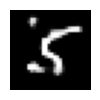

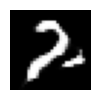

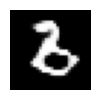

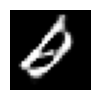

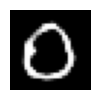

In [ ]:
train_gan(x_train,epochs,test_images)